# EDA and Initial model building

Loading in libraries

In [36]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [37]:
 class ModelWithCV(): #class acquired through Flatiron School
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

Loading in data in a pandas dataframe

In [38]:
df = pd.read_csv('../data/bigml_59c28831336c6604c800002a.csv')

Looking over in the Original dataframe before I alter

In [39]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [40]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [42]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [43]:
columns = list(df.columns)
[{(x, (len(df[x].value_counts()))): [df[x].value_counts()]} for x in columns]  
#Able to view the value_counts in each column

[{('state',
   51): [WV    106
   MN     84
   NY     83
   AL     80
   OR     78
   WI     78
   OH     78
   VA     77
   WY     77
   CT     74
   ID     73
   VT     73
   MI     73
   TX     72
   UT     72
   IN     71
   KS     70
   MD     70
   MT     68
   NC     68
   NJ     68
   CO     66
   NV     66
   WA     66
   MS     65
   MA     65
   RI     65
   AZ     64
   MO     63
   FL     63
   ME     62
   ND     62
   NM     62
   OK     61
   NE     61
   DE     61
   SD     60
   SC     60
   KY     59
   IL     58
   NH     56
   AR     55
   DC     54
   GA     54
   HI     53
   TN     53
   AK     52
   LA     51
   PA     45
   IA     44
   CA     34
   Name: state, dtype: int64]},
 {('account length',
   212): [105    43
   87     42
   93     40
   101    40
   90     39
          ..
   191     1
   199     1
   215     1
   221     1
   2       1
   Name: account length, Length: 212, dtype: int64]},
 {('area code',
   3): [415    1655
   510     840
   408     

Thoughts after a brief lookover in `.head()` , `.describe()` , and `.info()`
-  state and area code need to be one hot encoded
-  international plan and voice mail plan need to be converted from yes/no to binary 1/0
-  churn needs to be converted from True/False to 1/0???
-  don't need phone number column for making models.  Will `.drop()` because it will not provide helpful information for the model
-  All other columns will probably use in making model
-  Will need to scale depending on which estimators used in model building
-  Nothing seems too extreme or out of the normal in the `.describe()` so probably wont drop any outliers
-  No null values seen in `.info()`
    -Will do further exploration looking for empty ( ' ' ) cells or other variations of missing values
-  Will still do further exploration on other columns    

### Looking at the categorical columns that will need to be One Hot Encoded

In [44]:
len(df['state'].value_counts())

51

51 state???? Will need to make sure one is not repeated or typo.  If so, will need to combine with the correct state.

In [45]:
df['state'].value_counts().sort_index() 

AK     52
AL     80
AR     55
AZ     64
CA     34
CO     66
CT     74
DC     54
DE     61
FL     63
GA     54
HI     53
IA     44
ID     73
IL     58
IN     71
KS     70
KY     59
LA     51
MA     65
MD     70
ME     62
MI     73
MN     84
MO     63
MS     65
MT     68
NC     68
ND     62
NE     61
NH     56
NJ     68
NM     62
NV     66
NY     83
OH     78
OK     61
OR     78
PA     45
RI     65
SC     60
SD     60
TN     53
TX     72
UT     72
VA     77
VT     73
WA     66
WI     78
WV    106
WY     77
Name: state, dtype: int64

51 because including DC??? I believe they are refering to the District of Columbia.  This is fine.  I will leave this column alone until One hot encoding 

In [46]:
df['area code'].value_counts(normalize=False), df['area code'].value_counts(normalize=True)

(415    1655
 510     840
 408     838
 Name: area code, dtype: int64,
 415    0.496550
 510    0.252025
 408    0.251425
 Name: area code, dtype: float64)

I will leave this column alone until One hot encoding

.

.

.

### Looking at the Binary columns that will need to be converted to 1s and 0s

In [47]:
df.churn.value_counts(), df.churn.value_counts(normalize=True) #confirming binary before converting

(False    2850
 True      483
 Name: churn, dtype: int64,
 False    0.855086
 True     0.144914
 Name: churn, dtype: float64)

In [48]:
df.loc[df['churn'] == True, 'churn'] = 1  #converting True to 1
df.loc[df['churn'] == False, 'churn'] = 0  #converting False to 0
df['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [49]:
df['international plan'].value_counts(), df['international plan'].value_counts(normalize=True) 
#confirming binary before converting

(no     3010
 yes     323
 Name: international plan, dtype: int64,
 no     0.90309
 yes    0.09691
 Name: international plan, dtype: float64)

In [50]:
df['international plan'] = df['international plan'].replace('yes', 1) #replacing yes with 1
df['international plan'] = df['international plan'].replace('no', 0) #replacing no with 0
df['international plan'].value_counts()

0    3010
1     323
Name: international plan, dtype: int64

In [51]:
df['voice mail plan'].value_counts(), df['voice mail plan'].value_counts(normalize=True) #confirming binary before converting

(no     2411
 yes     922
 Name: voice mail plan, dtype: int64,
 no     0.723372
 yes    0.276628
 Name: voice mail plan, dtype: float64)

In [52]:
df['voice mail plan'] = df['voice mail plan'].replace('yes', 1) #replacing yes with 1
df['voice mail plan'] = df['voice mail plan'].replace('no', 0) #replacing no with 0
df['voice mail plan'].value_counts()

0    2411
1     922
Name: voice mail plan, dtype: int64

In [53]:
df.head()  # looking at dataframe to make sure changes were made

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


.

.

.

In [54]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [55]:
df.drop(columns='phone number', inplace=True) 
#removing the column 'phone number' because I don't think an ID equivilant information will be useful for model

Checking to make sure 'phone number' is removed

In [56]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

.

.

.

### Checking for other variations of missing values in dataframe 

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [58]:
np.where(df.applymap(lambda x: x == ' '))

(array([], dtype=int64), array([], dtype=int64))

In [59]:
np.where(df.applymap(lambda x: x == 'NA'))

(array([], dtype=int64), array([], dtype=int64))

In [60]:
np.where(df.applymap(lambda x: x == 'nan'))

(array([], dtype=int64), array([], dtype=int64))

In [61]:
np.where(df.applymap(lambda x: x == 'NaN'))

(array([], dtype=int64), array([], dtype=int64))

In [62]:
df = df.replace(' ', np.nan)  

In [63]:
df.isna().sum()

state                     0
account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

After further examination, there still appears to be no missing values in this dataset.

.

.

.

Looking into if there is appears to have account length and churn have an effect with eachother

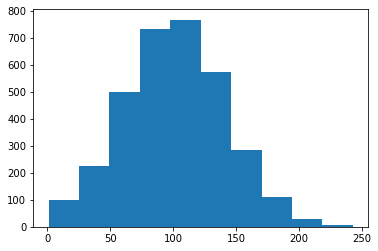

In [64]:
plt.hist(df['account length']);

100.79368421052632

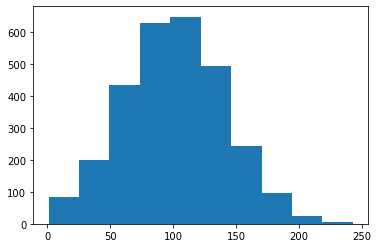

In [65]:
df_stay = df[df.churn == 0]
plt.hist(df_stay['account length']); df_stay['account length'].mean()

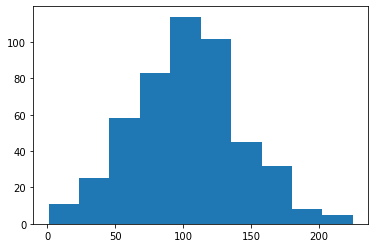

In [66]:
df_churn = df[df.churn == 1]
plt.hist(df_churn['account length']);

In [67]:
churn_acc_len_list = list(df_churn['account length'])

In [68]:
result = stats.ttest_1samp(churn_acc_len_list, df_stay['account length'].mean())
t_stat, p_value = result
result

Ttest_1sampResult(statistic=1.041798666402631, pvalue=0.2980272890643061)

There is not a large enoguh difference to say that there is a difference between account length between churn and not 

<AxesSubplot:>

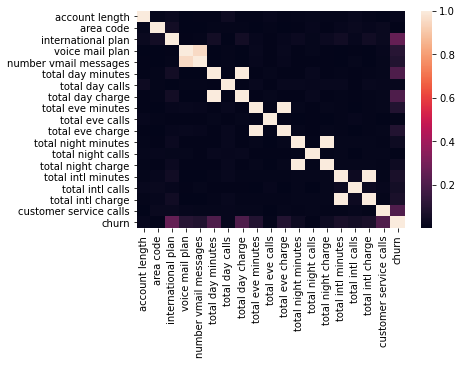

In [69]:
sns.heatmap(df.corr().abs())

<AxesSubplot:>

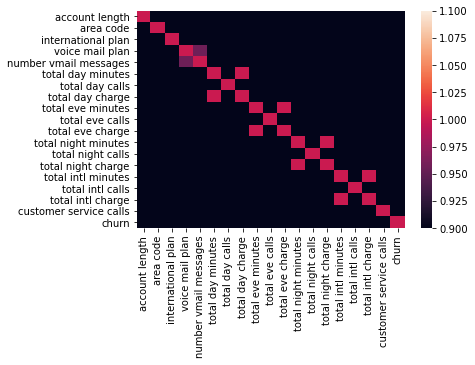

In [70]:
sns.heatmap(df.corr().abs(), vmin=.9, vmax=1.1)

In [71]:
voicemail = df[['number vmail messages', 'voice mail plan', 'total day charge', 'total day minutes' ,'total eve charge', 'total eve minutes','total night charge', 'total night minutes','total intl charge', 'total intl minutes']]
voicemail.corr()

,number vmail messages,voice mail plan,total day charge,total day minutes,total eve charge,total eve minutes,total night charge,total night minutes,total intl charge,total intl minutes
number vmail messages,1.000000,0.956927,0.000776,0.000778,0.017578,0.017562,0.007663,0.007681,0.002884,0.002856
voice mail plan,0.956927,1.000000,-0.001686,-0.001684,0.021559,0.021545,0.006064,0.006079,-0.001276,-0.001318
total day charge,0.000776,-0.001686,1.000000,1.000000,0.007036,0.007050,0.004301,0.004324,-0.010094,-0.010157
total day minutes,0.000778,-0.001684,1.000000,1.000000,0.007029,0.007043,0.004300,0.004323,-0.010092,-0.010155
total eve charge,0.017578,0.021559,0.007036,0.007029,1.000000,1.000000,-0.012601,-0.012592,-0.011074,-0.011043
total eve minutes,0.017562,0.021545,0.007050,0.007043,1.000000,1.000000,-0.012593,-0.012584,-0.011067,-0.011035
total night charge,0.007663,0.006064,0.004301,0.004300,-0.012601,-0.012593,1.000000,0.999999,-0.015186,-0.015214
total night minutes,0.007681,0.006079,0.004324,0.004323,-0.012592,-0.012584,0.999999,1.000000,-0.015180,-0.015207
total intl charge,0.002884,-0.001276,-0.010094,-0.010092,-0.011074,-0.011067,-0.015186,-0.015180,1.000000,0.999993
total intl minutes,0.002856,-0.001318,-0.010157,-0.010155,-0.011043,-0.011035,-0.015214,-0.015207,0.999993,1.000000


Need to drop one features between the colinear sets (have a correlation coef ~1)
- total day charge | total day minutes
- total eve charge | total eve minutes
- total night charge | total night minutes
- total int charge | total intl minutes

Number vmail messages | voice mail plan ~.95 should i remove?

In [72]:
df = df.drop(columns=['total day minutes','total eve minutes','total night minutes','total intl minutes'])
df

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,0,1,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0
1,OH,107,415,0,1,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0
2,NJ,137,415,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0
3,OH,84,408,1,0,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0
4,OK,75,415,1,0,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,0,1,36,77,26.55,126,18.32,83,12.56,6,2.67,2,0
3329,WV,68,415,0,0,0,57,39.29,55,13.04,123,8.61,4,2.59,3,0
3330,RI,28,510,0,0,0,109,30.74,58,24.55,91,8.64,6,3.81,2,0
3331,CT,184,510,1,0,0,105,36.35,84,13.57,137,6.26,10,1.35,2,0


<AxesSubplot:>

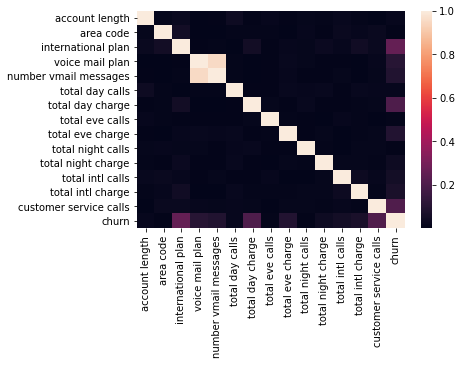

In [73]:
sns.heatmap(df.corr().abs())

In [74]:
df.to_csv('../data/clean_df.csv')

Lookin into total day charged

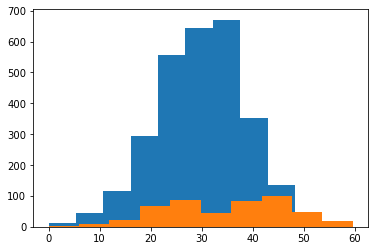

In [75]:
plt.hist(df_stay['total day charge']), plt.hist(df_churn['total day charge']);

In [76]:
churn_tdc_list = list(df_churn['total day charge'])
result = stats.ttest_1samp(churn_tdc_list, df_stay['total day charge'].mean())
t_stat, p_value = result
result

Ttest_1sampResult(statistic=10.109228512661401, pvalue=6.4305424235249905e-22)

There is a difference!!

In [77]:
df_stay['total day charge'].mean(), df_churn['total day charge'].mean()

(29.780421052631578, 35.17592132505176)

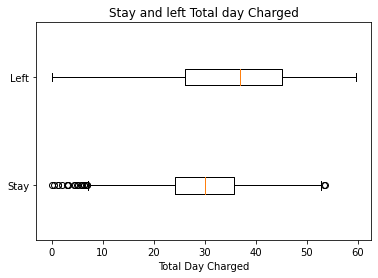

In [78]:
boxs = {'Stay': df_stay['total day charge'], 'Left':df_churn['total day charge']}
fig, ax = plt.subplots()
ax.boxplot(boxs.values(), vert=False)
ax.set_yticklabels(boxs.keys())
ax.set_xlabel('Total Day Charged')
ax.set_title('Stay and left Total day Charged');  

In [79]:
churn_tdc_quartiles = np.percentile(churn_tdc_list, [25,50,75]) 
stay_tdc_quartiles = np.percentile(list(df_stay['total day charge']), [25,50,75])

print(f"""
Churn quartiles on total day charged {churn_tdc_quartiles}. \n
Customers still doing service with quartiles on total day charged {stay_tdc_quartiles}."""
)


Churn quartiles on total day charged [26.055 36.99  45.21 ]. 

Customers still doing service with quartiles on total day charged [24.2825 30.12   35.75  ].


In [80]:
df_stay_viz = df_stay.copy()
df_churn_viz = df_churn.copy()

In [81]:
vc0 = df_churn_viz.loc[df_churn_viz['total day charge'] <= churn_tdc_quartiles[0]]
vc1 = df_churn_viz.loc[df_churn_viz['total day charge'] <= churn_tdc_quartiles[1]]
vc2 = df_churn_viz.loc[df_churn_viz['total day charge'] <= churn_tdc_quartiles[2]]
vc3 = df_churn_viz.loc[df_churn_viz['total day charge'] >= churn_tdc_quartiles[2]]
vc_mean = [vc0['total day charge'].mean(), vc1['total day charge'].mean(),vc2['total day charge'].mean(),vc3['total day charge'].mean()]

vs0 = df_stay_viz.loc[df_stay_viz['total day charge'] <= stay_tdc_quartiles[0]]
vs1 = df_stay_viz.loc[df_stay_viz['total day charge'] <= stay_tdc_quartiles[1]]
vs2 = df_stay_viz.loc[df_stay_viz['total day charge'] <= stay_tdc_quartiles[2]]
vs3 = df_stay_viz.loc[df_stay_viz['total day charge'] >= stay_tdc_quartiles[2]]
vs_mean = [vs0['total day charge'].mean(), vs1['total day charge'].mean(),vs2['total day charge'].mean(),vs3['total day charge'].mean()]

In [82]:
vc_mean, vs_mean

([19.819917355371903, 25.14111570247934, 30.40419889502763, 49.45165289256199],
 [18.680575035063114,
  22.974205738278517,
  26.286816269284714,
  40.27163865546218])

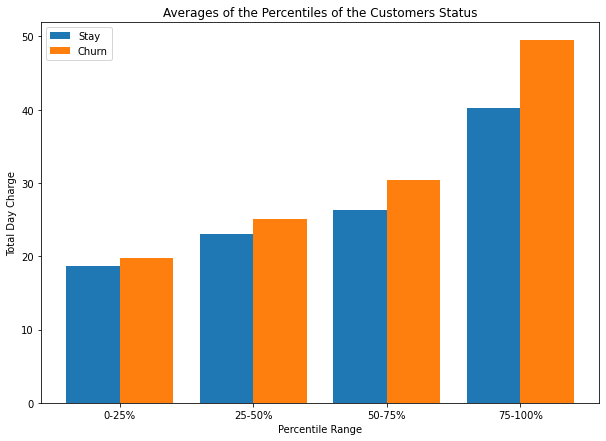

In [123]:
#Plot median performance at the box office

fig,ax = plt.subplots(figsize = (10,7))

labels = ['0-25%','25-50%','50-75%', '75-100%']
#Graphs for median gross/net revenue by the month
x = np.arange(len(labels)) 
w = 0.4

ax.set_title(f'Averages of the Percentiles of the Customers Status')

ax.bar(x-w/2, vs_mean, w)
ax.bar(x+w/2, vc_mean, w)

plt.xticks(x, labels=labels)
ax.set_xlabel('Percentile Range')
ax.set_ylabel('Total Day Charge')

ax.legend(['Stay', 'Churn'])

fig.savefig('../images/customers_status_percentile_averages.jpg',
             transparent = False,bbox_inches="tight", dpi=500);

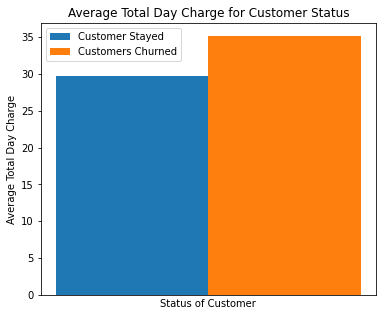

In [84]:
# Numbers of pairs of bars you want
N = 1

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (df_stay['total day charge'].mean())
# Specify the values of orange bars (height)
orange_bar = (df_churn['total day charge'].mean())

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(6,5))

# Width of a bar 
width = 0.2      

# Plotting
plt.bar(ind, blue_bar , width, label='Customer Stayed')
plt.bar(ind + width, orange_bar, width, label='Customers Churned')

plt.xlabel('Status of Customer')
plt.ylabel('Average Total Day Charge')
plt.title('Average Total Day Charge for Customer Status')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks([])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

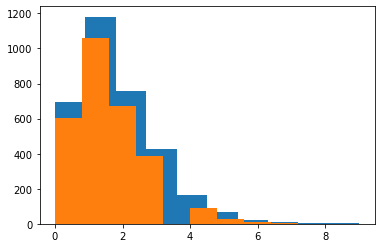

In [85]:
plt.hist(df['customer service calls']), plt.hist(df_stay['customer service calls']);


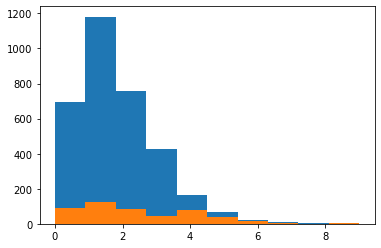

In [86]:
plt.hist(df['customer service calls']), plt.hist(df_churn['customer service calls']);

Line graph showing the percentage rate change or stacked bar 

In [87]:
df_viz = df.copy()

In [88]:
df_viz.loc[df_viz['customer service calls'] >= 6, 'customer service calls'] = 6

In [89]:
df_viz['customer service calls'].value_counts().sort_index().index

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

In [90]:
df_viz_churn = df_viz[df_viz.churn==1]

In [91]:
df_viz['customer service calls'].value_counts().sort_index().index.tolist()

[0, 1, 2, 3, 4, 5, 6]

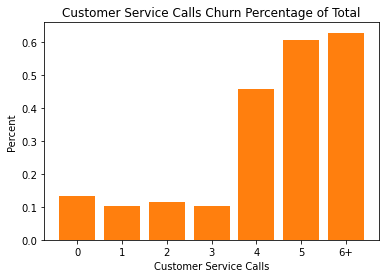

In [117]:
# fig, ax=plt.subplots(figsize=(15,8))

plt.bar((df_viz['customer service calls'].value_counts().sort_index().index), (df_viz_churn['customer service calls'].value_counts().sort_index().values / df_viz['customer service calls'].value_counts().sort_index().values),
       color='tab:orange')

plt.xticks(ticks=df_viz['customer service calls'].value_counts().sort_index().index, labels=['0','1','2','3','4','5','6+'])
plt.xlabel('Customer Service Calls')
plt.ylabel('Percent')
plt.title('Customer Service Calls Churn Percentage of Total')

plt.savefig('../images/customers_service_calls.jpg',
            transparent = False,bbox_inches="tight")
plt.show();

In [93]:
df_viz_churn['customer service calls'].value_counts().sort_index().values

array([ 92, 122,  87,  44,  76,  40,  22], dtype=int64)

In [94]:
df_viz['customer service calls'].value_counts().sort_index().values

array([ 697, 1181,  759,  429,  166,   66,   35], dtype=int64)

appears that by 4 customers calls ooks like a drastic amount of people drop or switch to a different provider.

.

.

Lookin into International Feature

In [95]:
no_int_len = len(df[df["international plan"]==0])
int_len = len(df[df["international plan"]==1])

no_int_chrun_len = len(df.loc[(df["international plan"]==0) & (df.churn == 1)])
int_chrun_len = len(df.loc[(df["international plan"]==1) & (df.churn == 1)])

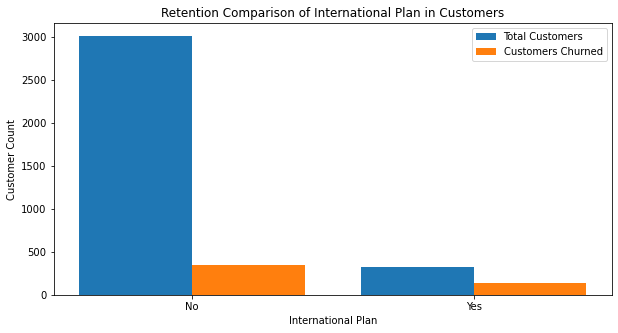

In [111]:
# Numbers of pairs of bars you want
N = 2

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (no_int_len, int_len)
# Specify the values of orange bars (height)
orange_bar = (no_int_chrun_len, int_chrun_len)

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.4      

# Plotting
plt.bar(ind, blue_bar , width, label='Total Customers')
plt.bar(ind + width, orange_bar, width, label='Customers Churned')

plt.xlabel('International Plan')
plt.ylabel('Customer Count')
plt.title('Retention Comparison of International Plan in Customers')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('No', 'Yes'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.savefig('../images/retention_comparison_interrnational_plan.jpg')
plt.show();

In [97]:
no_international_churn = no_int_chrun_len / no_int_len *100

international_churn = int_chrun_len / int_len *100

print(f' Percent of people who churn when they do not have an international plan {round(no_international_churn)}%')
print(f' Percent of people who churn when they do have an international plan {round(international_churn)}%')

 Percent of people who churn when they do not have an international plan 11%
 Percent of people who churn when they do have an international plan 42%


.

.

.

### One Hot Encoding

In [98]:
df[['state','area code']] #Looking at the Categorical columns

,state,area code
0,KS,415
1,OH,415
2,NJ,415
3,OH,408
4,OK,415
...,...,...
3328,AZ,415
3329,WV,415
3330,RI,510
3331,CT,510


In [99]:
cat_cols = df[['state','area code']]  #subsetting columns that will be transformed

ohe = OneHotEncoder(
    drop='first',
    sparse=False)  #instantiate encoder

dums = ohe.fit_transform(cat_cols)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=cat_cols.index)
df_clean = pd.concat([df, dums_df], axis=1)  #concatinating created OHE dataframe with old datafra
df_clean.drop(columns=cat_cols, inplace=True) #remooving orignal columns after beinhg OHE
df_clean #looking at dataframe if it performed correctly 

C:\Users\weesn\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,account length,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,...,x0_TX,x0_UT,x0_VA,x0_VT,x0_WA,x0_WI,x0_WV,x0_WY,x1_415,x1_510
0,128,0,1,25,110,45.07,99,16.78,91,11.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,107,0,1,26,123,27.47,103,16.62,103,11.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,137,0,0,0,114,41.38,110,10.30,104,7.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,84,1,0,0,71,50.90,88,5.26,89,8.86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75,1,0,0,113,28.34,122,12.61,121,8.41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,77,26.55,126,18.32,83,12.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3329,68,0,0,0,57,39.29,55,13.04,123,8.61,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3330,28,0,0,0,109,30.74,58,24.55,91,8.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3331,184,1,0,0,105,36.35,84,13.57,137,6.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [100]:
# X_train_cat = X_train.select_dtypes('object')

# ohe = OneHotEncoder(
#     drop='first',
#     sparse=False)

# dums = ohe.fit_transform(X_train_cat)
# dums_df = pd.DataFrame(dums,
#                        columns=ohe.get_feature_names(),
#                        index=X_train_cat.index)
# X_train_nums = X_train.select_dtypes('float64')

# ss = StandardScaler()

# ss.fit(X_train_nums)
# nums_df = pd.DataFrame(ss.transform(X_train_nums),
#                       index=X_train_nums.index)
# X_train_clean = pd.concat([nums_df, dums_df], axis=1)

In [101]:
X = df_clean.drop(columns='churn')
y = df_clean.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=3)

In [102]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Baseline model/ Dummy Model:

In [103]:
dr = DummyClassifier()

dummy_model = dr.fit(X_train, y_train)
dummy_train =dr.score(X_train,y_train)
dummy_test = dr.score(X_test,y_test)

print(f'Train: {dummy_train}')
print(f'Test : {dummy_test}')

Train: 0.8486341244961935
Test : 0.8681818181818182


Looking into target having a class imbalance

In [104]:
df.churn.value_counts(), df.churn.value_counts(normalize=True)

(0    2850
 1     483
 Name: churn, dtype: int64,
 0    0.855086
 1    0.144914
 Name: churn, dtype: float64)

There is a class imbalance so will use SMOTE to generate synthetic data to supplement the minority class

In [105]:
sm = SMOTE(sampling_strategy='minority', random_state=3)
X_resmp, y_resmp = sm.fit_resample(X_train, y_train)

y_resmp.value_counts()

1    1895
0    1895
Name: churn, dtype: int64

First simple model/ LogisticRegression Model :

In [106]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8692342140618002, 0.87)

First model is slightly worse than the Baseline model

First complex model / RandomForestClassifier:

In [107]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled,y_train)
forest = ModelWithCV(rfc, 'forest_pipe', X_train_scaled, y_train)
rfc.score(X_train_scaled,y_train) , forest.cv_results

(1.0,
 array([0.90178571, 0.91517857, 0.92410714, 0.94170404, 0.92376682,
        0.9058296 , 0.9058296 , 0.92825112, 0.93273543, 0.89237668]))

Better accuracy than baseline and previous model but model is overfit.

Hyperparamter tuning:

In [108]:
rfc = RandomForestClassifier(max_depth=5)
rfc.fit(X_train_scaled,y_train)
forest = ModelWithCV(rfc, 'forest_pipe', X_train_scaled, y_train)
rfc.score(X_train_scaled,y_train) , forest.cv_results.mean()

(0.8557993730407524, 0.8504264093529788)

Better fit than the previous model and better accuracy than the baseline

In [139]:
pd.merge(X_test, y_test, right_index=True, left_index=True)

,account length,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,...,x0_UT,x0_VA,x0_VT,x0_WA,x0_WI,x0_WV,x0_WY,x1_415,x1_510,churn
2814,146,0,0,0,77,19.65,100,18.16,72,9.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
914,179,0,0,0,123,48.84,114,24.48,112,11.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1615,74,0,0,0,95,26.71,36,18.11,77,12.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2377,101,0,1,36,125,21.03,106,14.67,127,12.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1088,105,0,1,42,79,17.32,97,18.96,77,10.87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,112,0,0,0,76,36.91,100,17.44,91,8.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
765,113,0,0,0,97,31.89,118,17.70,101,7.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2201,116,0,0,0,128,15.22,137,15.37,94,8.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
631,169,0,0,0,112,17.14,69,19.55,95,8.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
